In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv", encoding = 'ISO-8859-1', low_memory = False)

In [3]:
# Посмотрим на данные:

# client_id - идентификатор клиента
# education - уровень образования
# sex - пол заёмщика
# age - возраст заёмщика
# car - флаг наличия автомобиля
# car_type - флаг автомобиля-иномарки
# decline_app_cnt - количество отказанных прошлых заявок
# good_work - флаг наличия «хорошей» работы
# bki_request_cnt - количество запросов в БКИ
# home_address - категоризатор домашнего адреса
# work_address - категоризатор рабочего адреса
# income - доход заёмщика
# foreign_passport - наличие загранпаспорта
# default - наличие дефолта

train.sample(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
12448,6927,GRD,F,33,N,N,0,0,0,1,2,100000,N,0
38,74699,GRD,F,26,N,N,1,0,0,1,3,26000,N,0
62919,47966,SCH,M,30,Y,N,0,0,0,2,3,40000,N,0
48384,95452,SCH,F,62,N,N,0,0,1,2,3,10000,N,0
44249,66931,GRD,M,31,Y,N,1,1,5,1,2,42000,Y,0


In [4]:
# Сколько записей содержит набор данных для моделирования?

train.shape[0]

73799

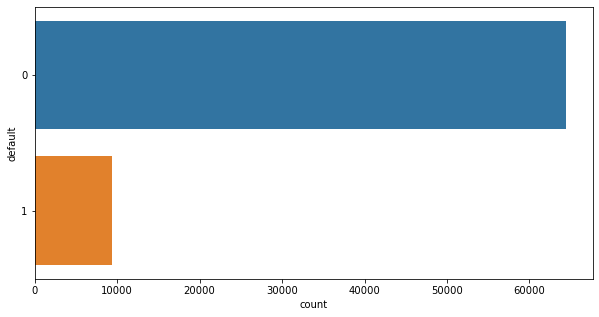

In [18]:
# Постройте диаграмму для переменной default. Каких клиентов у банка больше?

plt.figure(figsize=(10, 5))

ax = sns.countplot(y = train.default)

In [6]:
# Посмотрим на тип данных и наличие пропусков:

display(train.info())

display(train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


None

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

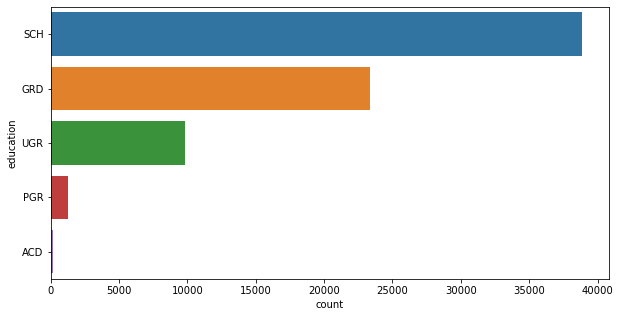

In [17]:
# Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

plt.figure(figsize=(10, 5))

ax = sns.countplot(y = train.education)

In [25]:
# Заполним пропуски в поле 'education' самым частым значением:

train.education = train.education.fillna(train.education.value_counts().idxmax())

In [29]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73799 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


None

In [30]:
# Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) 
# для дальнейшего удобного анализа.

# Бинарные переменные:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

# Категориальные переменные:
cat_cols = ['education', 'home_address', 'work_address']

# Числовые переменные:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

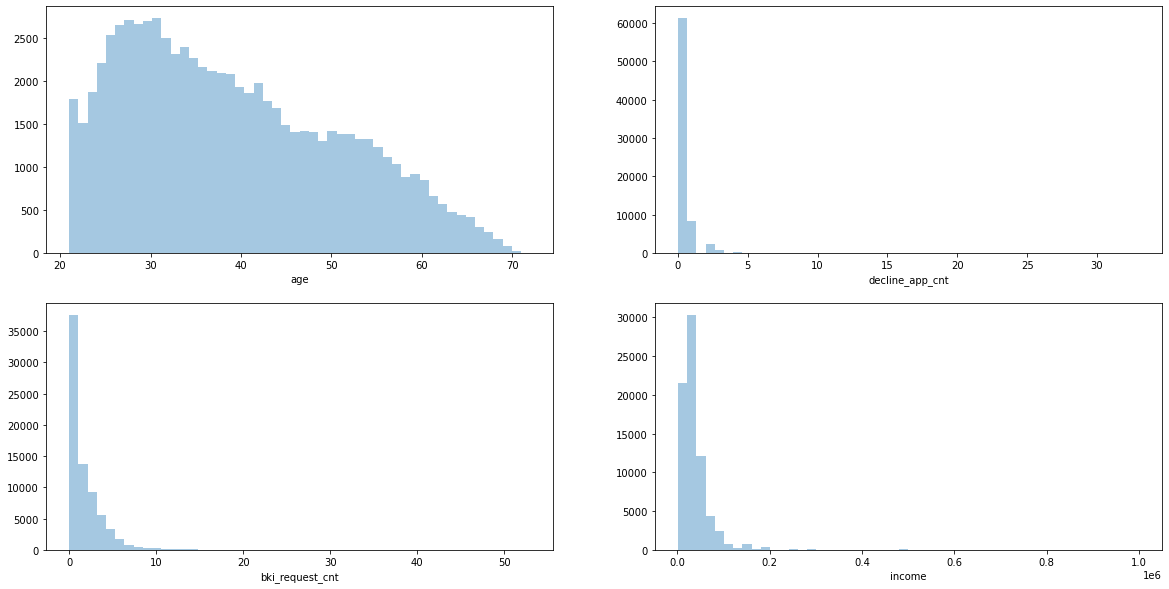

In [37]:
# Посмотрим на распределение числовых данных:

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for col, i in zip(num_cols, range(4)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [38]:
# Распределения всех числовых признаков имеют сильное смещение вправо. Для того чтобы сделать распределение 
# данных переменных более нормальным, можно работать с логарифмированными величинами этих переменных. 

for i in num_cols:
    train[i] = np.log(train[i] + 1)

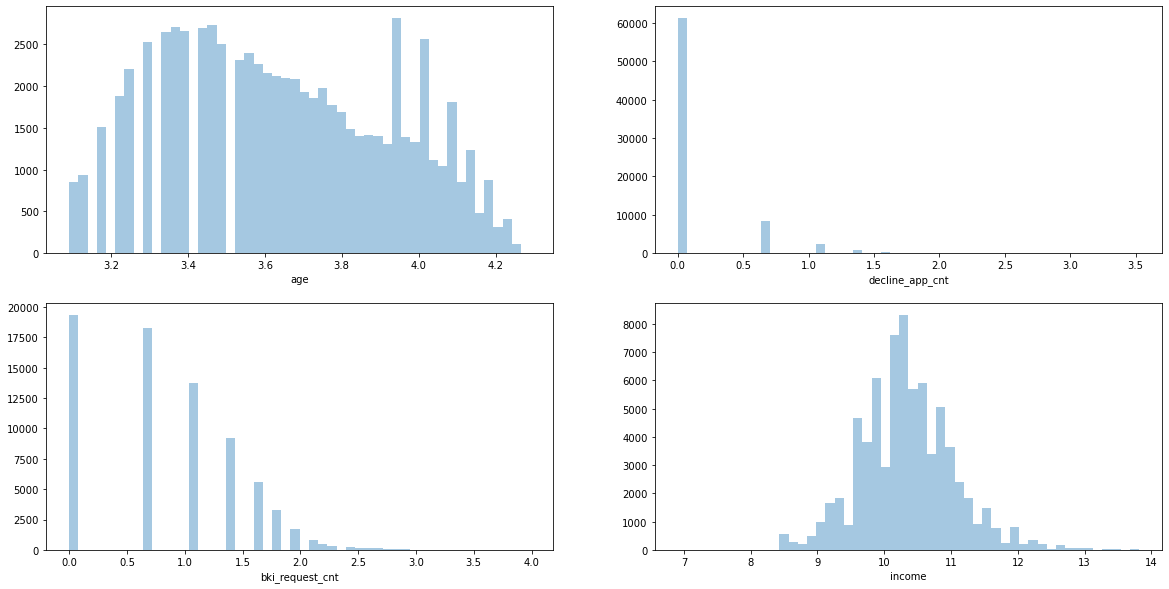

In [39]:
# Посмотрим как изменилось распределение числовых данных:

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for col, i in zip(num_cols, range(4)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

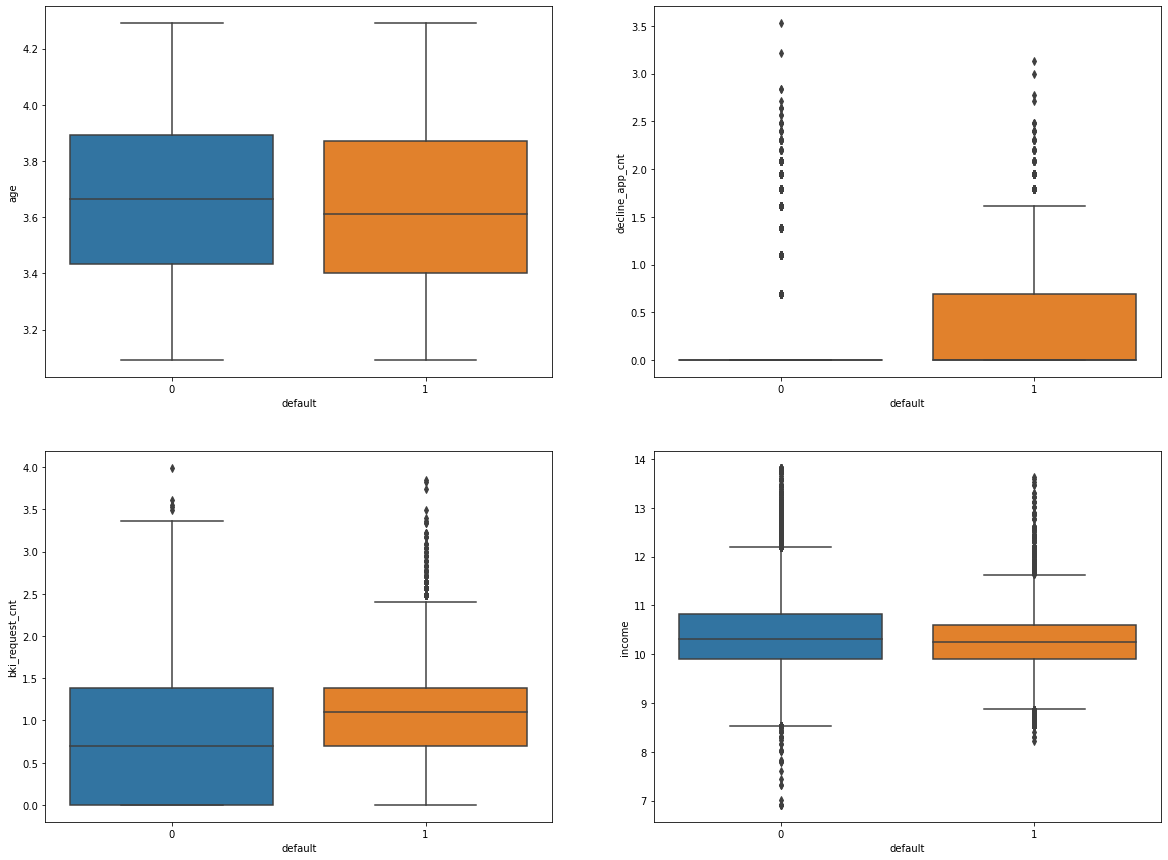

In [64]:
# Посмотрим boxplot числовых признаков:

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
for col, i in zip(num_cols, range(4)):
    sns.boxplot(x = train.default, y = train[col], ax=axes.flat[i])

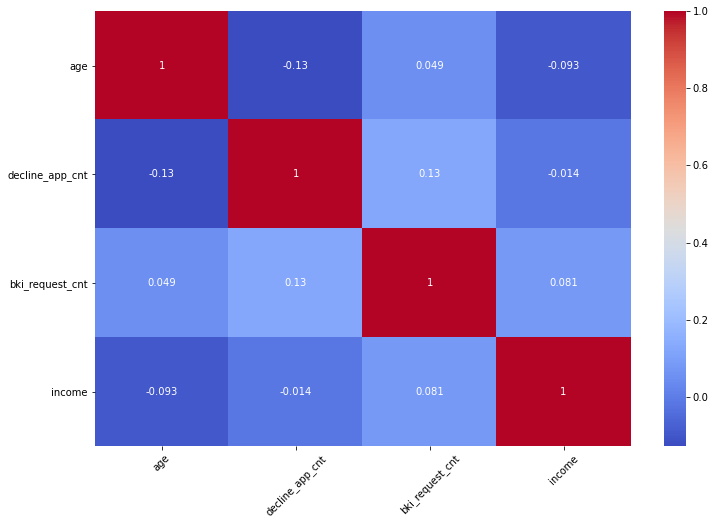

In [74]:
# Построим тепловую карту матрицы корреляций числовых признаков:

plt.figure(figsize = (12, 8))

ax = sns.heatmap(train[num_cols].corr(), annot=True, cmap='coolwarm')
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.show()

In [65]:
train[num_cols]

,age,decline_app_cnt,bki_request_cnt,income
0,4.143135,0.000000,0.693147,9.798183
1,4.094345,0.000000,1.386294,9.852247
2,3.258097,1.098612,0.693147,10.308986
3,3.988984,0.000000,1.098612,9.210440
4,3.891820,0.000000,0.693147,10.308986
...,...,...,...,...
73794,3.828641,0.000000,1.386294,9.741027
73795,3.737670,0.000000,0.693147,11.156265
73796,3.465736,0.000000,1.609438,10.714440
73797,3.401197,0.000000,1.386294,9.472782
